In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.preproc.preproc import reduce_bias, reduce_dark, combine_image
from kspecdr.tlm.make_tlm import read_instrument_data, make_tlm
from scipy.signal import find_peaks_cwt, find_peaks
from rascal.util import refine_peaks
from matplotlib.lines import Line2D
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(name)s | %(levelname)s | %(message)s"
    )

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_commissioning" / "260119"

/home/hbahk/miniconda3/envs/twodfdr/lib/python3.12/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
bias_files = list(TESTDIR.glob("bias_*.fits"))
# dark_files = list(TESTDIR.glob("dark_*.fits"))

bias_files_converted = [TESTDIR / f.name.replace("bias_", "cbias_") for f in bias_files]

for bfpath, bfpath_converted in zip(bias_files, bias_files_converted):
    hdul = fits.open(bfpath)
    hdr = hdul[0].header
    new_hdr = convert_isoplane_header(hdr, ndfclass="BIAS")
    hdul[0].header = new_hdr
    # use the first frame - (1, 1340, 1300) --> (1340, 1300)
    hdul[0].data = hdul[0].data[0]
    # make new fits file with new header and fiber table
    new_hdr["NAXIS"] = 2
    # new_hdr.remove("NAXIS3")
    hdul[0].header = new_hdr
    hdul.writeto(bfpath_converted, overwrite=True)


mbias_path = TESTDIR / "mbias.fits"
mbias_file = reduce_bias(bias_files_converted, output_file=mbias_path.as_posix())

# mdark_path = TESTDIR / "mdark.fits"
# mdark_file = reduce_dark(
#     dark_files, output_file=mdark_path.as_posix(), bias_filename=mbias_path.as_posix()
# )

2026-01-23 23:22:52,995 | kspecdr.preproc.preproc | INFO | Reducing 15 bias frames
2026-01-23 23:22:52,995 | kspecdr.preproc.make_im | INFO | ==================================================
2026-01-23 23:22:52,995 | kspecdr.preproc.make_im | INFO | Preprocessing image data contained in RAW frame
2026-01-23 23:22:52,996 | kspecdr.preproc.make_im | INFO | ==================================================
2026-01-23 23:22:52,996 | kspecdr.preproc.make_im | INFO | RAW file = /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cbias_00001.fits
2026-01-23 23:22:52,996 | kspecdr.preproc.make_im | INFO | Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
2026-01-23 23:22:52,996 | kspecdr.preproc.make_im | INFO | Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cbias_00001.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cbias_00001_im.fits
2026-01-23 23:22:53,004 | kspecdr.io.ima

In [94]:
hdul = fits.open(TESTDIR / "flat_00001.fits")
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=14)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "cflat_00001.fits"
hdul.writeto(new_fpath, overwrite=True)

2026-01-24 13:45:52,824 | astropy | WARNING | TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days
2026-01-24 13:45:52,826 | kspecdr.inst.isoplane | INFO | Adding fiber table with 14 fibers


In [100]:
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/flat_00001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     146   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   14R x 2C   ['1A', '20A']   


In [101]:
Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


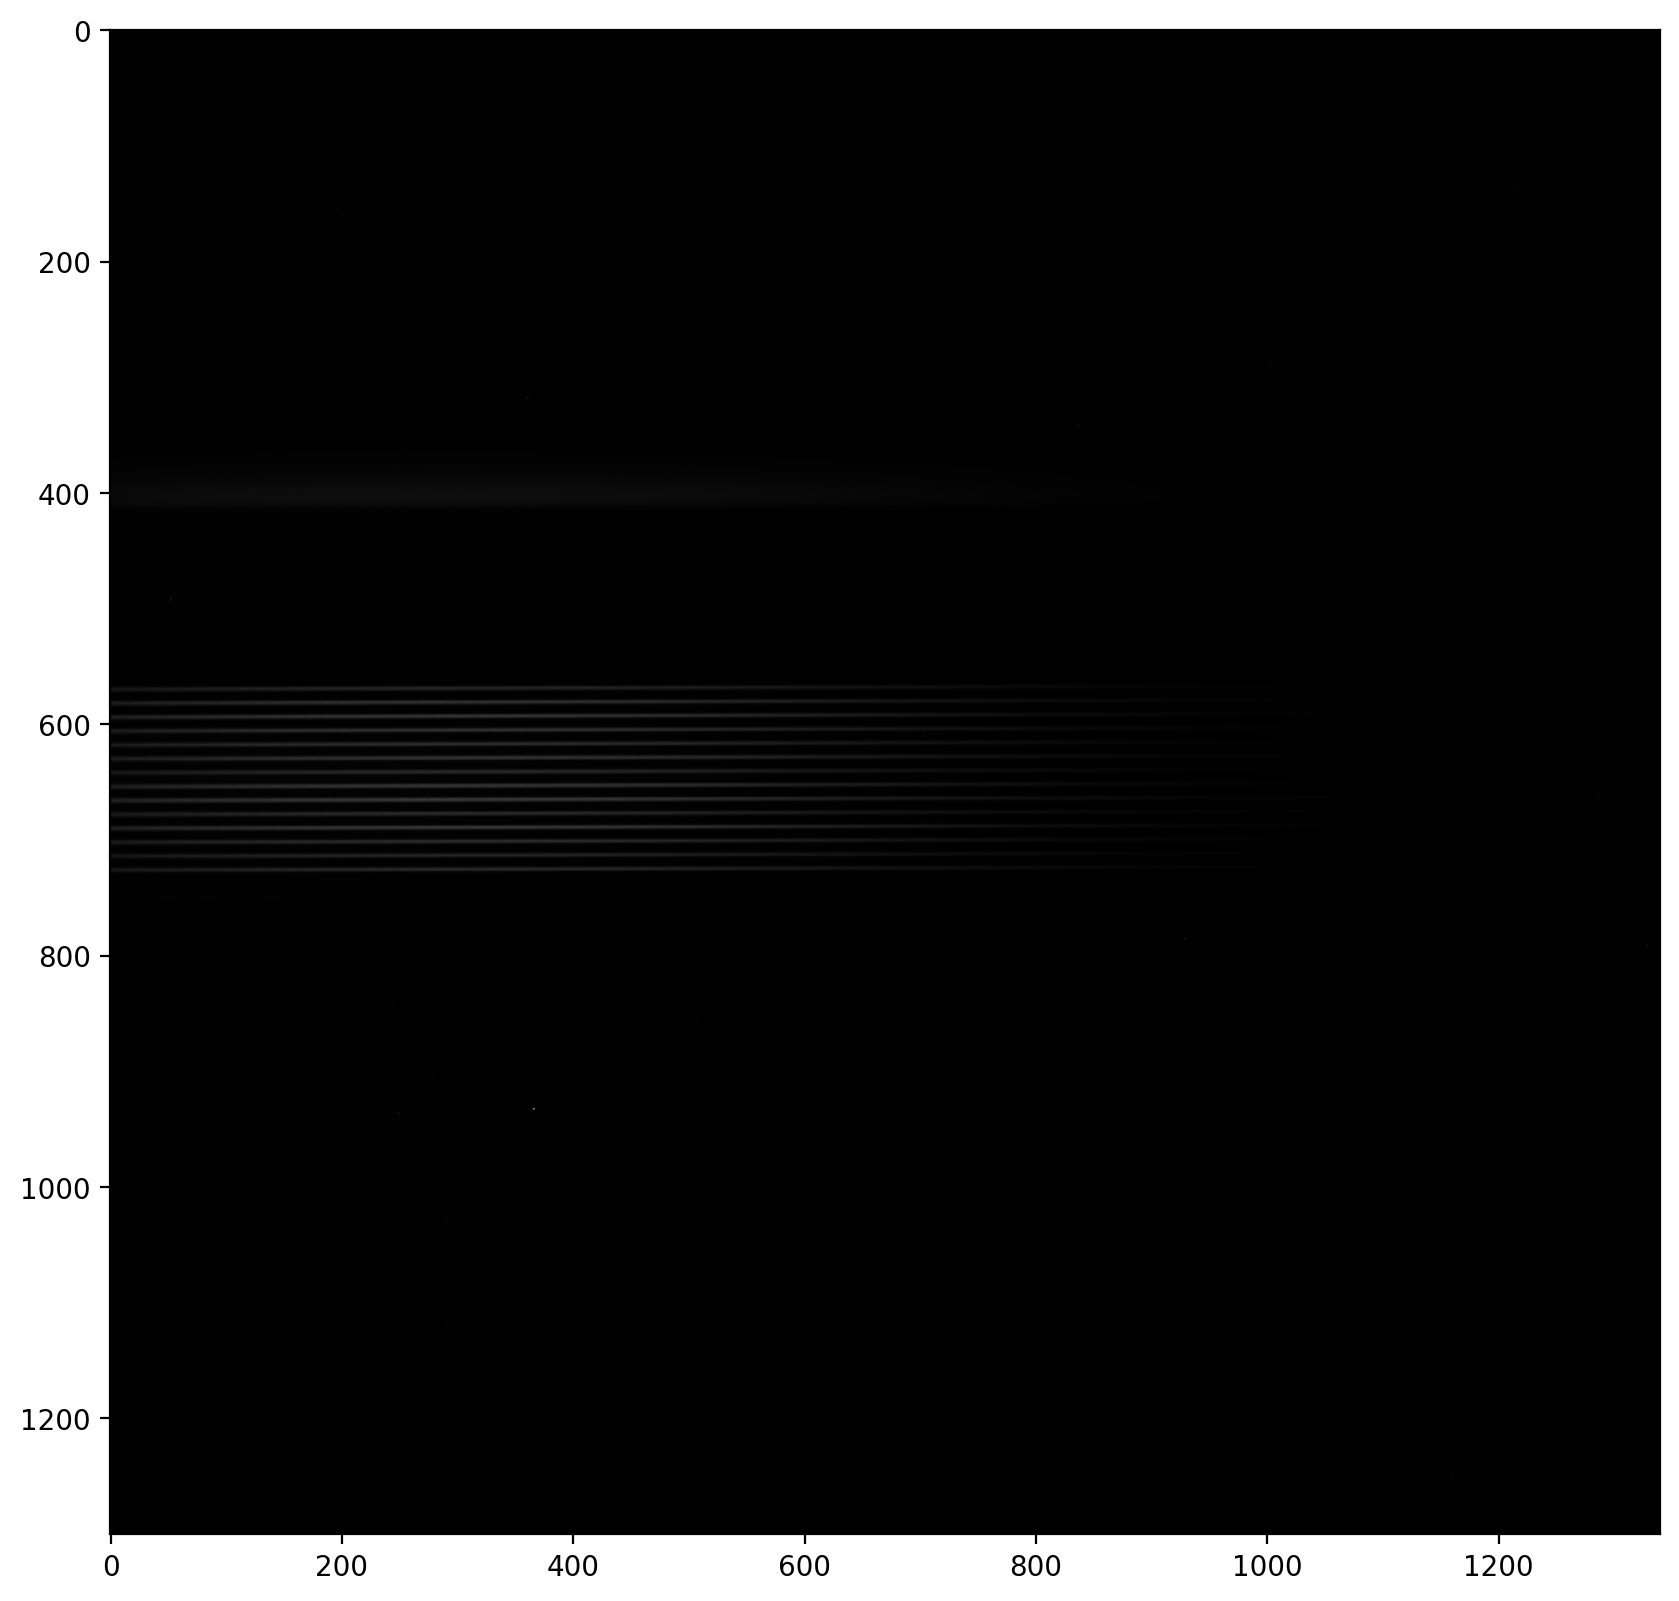

In [103]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

In [104]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode='READ')
im.open()


make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        bias_filename=mbias_path.as_posix(),
        use_bias=True,
        verbose=False)

2026-01-24 13:47:00,629 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits (mode: READ)
2026-01-24 13:47:00,630 | kspecdr.preproc.make_im | INFO | Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
2026-01-24 13:47:00,630 | kspecdr.preproc.make_im | INFO | Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-24 13:47:00,635 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits (mode: READ)
2026-01-24 13:47:00,636 | kspecdr.preproc.make_im | INFO | Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
2026-01-24 13:47:00,636 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits
2026-01-24 1

2026-01-24 13:47:00,674 | kspecdr.preproc.make_im | INFO | Copying fiber table from source file
2026-01-24 13:47:00,677 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: UPDATE)
2026-01-24 13:47:00,679 | kspecdr.io.image | INFO | Copied fiber table 'FIBRES' from source file
2026-01-24 13:47:00,710 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-24 13:47:00,710 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits
2026-01-24 13:47:00,711 | kspecdr.preproc.make_im | INFO | Successfully created IM file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-24 13:47:00,717 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: UPDA

'/data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits'

In [105]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 99)

2026-01-24 13:47:02,215 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: READ)


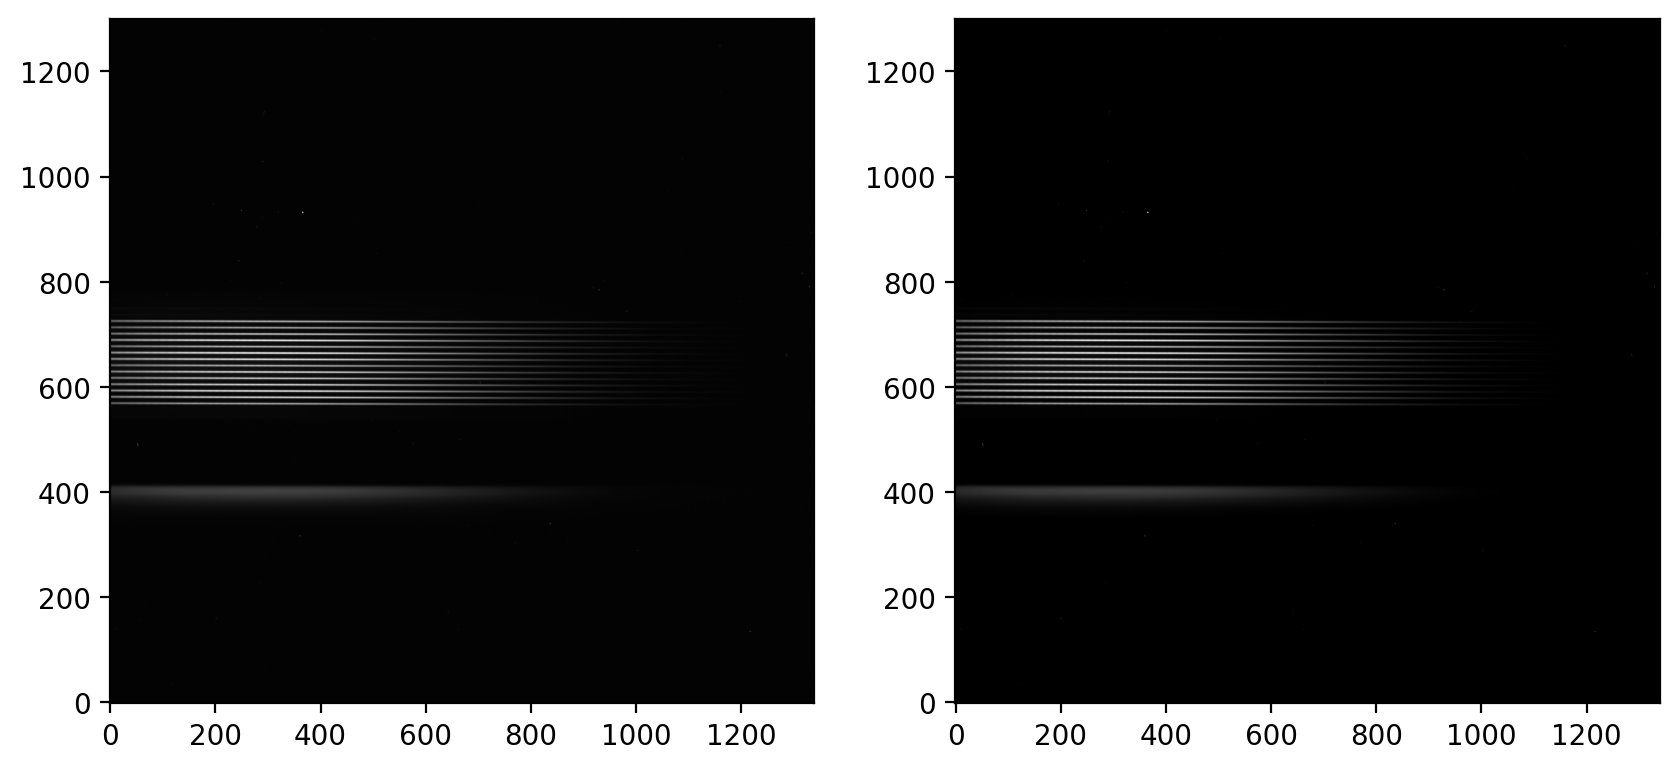

(1300, 1340)
(1300, 1340)


In [106]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_data, cmap='gray', origin='lower')
axes[1].imshow(var_data, cmap='gray', origin='lower')
plt.show()
print(img_data.shape)
print(var_data.shape)

In [107]:
hdul = fits.open(TESTDIR / "flat_00002.fits")
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=14)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "cflat_00002.fits"
hdul.writeto(new_fpath, overwrite=True)

args = {"IMAGE_FILENAME": new_fpath.as_posix()}

make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        bias_filename=mbias_path.as_posix(),
        use_bias=True,
        verbose=False)

2026-01-24 13:47:04,497 | astropy | WARNING | TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days
2026-01-24 13:47:04,499 | kspecdr.inst.isoplane | INFO | Adding fiber table with 14 fibers
2026-01-24 13:47:04,518 | kspecdr.preproc.make_im | INFO | Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
2026-01-24 13:47:04,518 | kspecdr.preproc.make_im | INFO | Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00002.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00002_im.fits
2026-01-24 13:47:04,522 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00002.fits (mode: READ)
2026-01-24 13:47:04,523 | kspecdr.preproc.make_im | INFO | Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
2026-01-24 13:47:04,524 | kspecdr.io.image | INFO | Closed file: /data1/hb

'/data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00002_im.fits'

2026-01-24 13:48:12,532 | kspecdr.preproc.preproc | INFO | Combining 2 images into /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat.fits using MEAN
2026-01-24 13:48:12,536 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: READ)
2026-01-24 13:48:12,537 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-24 13:48:12,539 | kspecdr.preproc.preproc | INFO | Reading /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (1/2)
2026-01-24 13:48:12,541 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: READ)
2026-01-24 13:48:12,549 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-24 13:48:12,549 | kspecdr

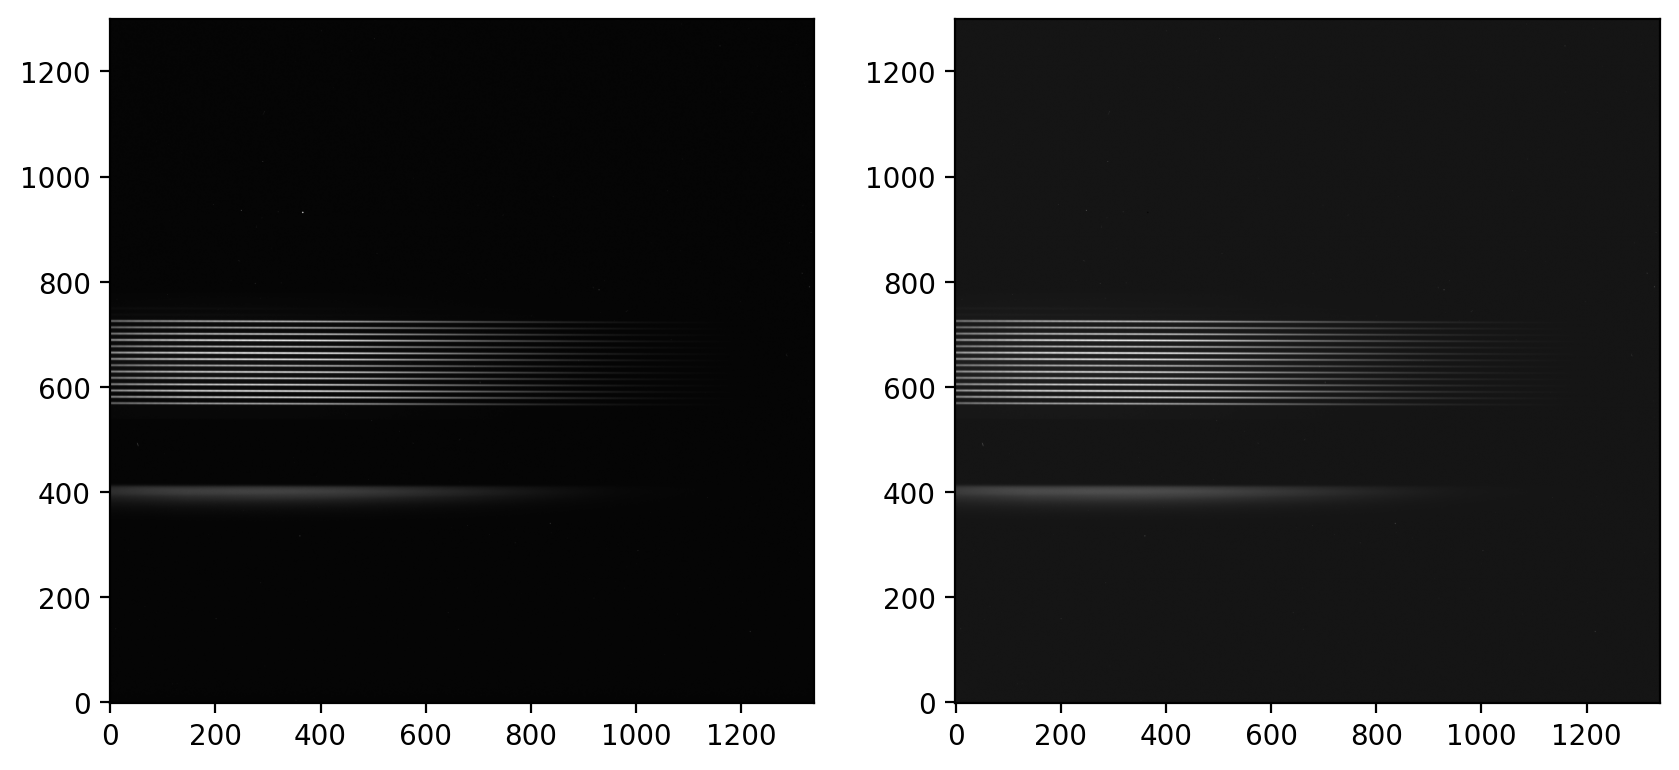

(1300, 1340)
(1300, 1340)


In [112]:
mcflat_path = new_fpath.parent / "mcflat.fits"

combine_image([new_fpath.as_posix().replace("00002.fits", "00001_im.fits"), new_fpath.as_posix().replace("00002.fits", "00002_im.fits")], 
              output_file=mcflat_path.as_posix(),
              method='MEAN',
              adjust_levels=True)


im = ImageFile(mcflat_path.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 99)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_data, cmap='gray', origin='lower')
axes[1].imshow(var_data, cmap='gray', origin='lower')
plt.show()
print(img_data.shape)
print(var_data.shape)

In [129]:
logging.getLogger("kspecdr.tlm.make_tlm").setLevel(logging.INFO)
fpath_tlm = mcflat_path.parent / (mcflat_path.stem + "_tlm.fits")
args = {"IMAGE_FILENAME": mcflat_path.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix()}

make_tlm(args)

2026-01-24 14:23:05,554 | kspecdr.tlm.make_tlm | INFO | Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat.fits
2026-01-24 14:23:05,557 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat.fits (mode: READ)
2026-01-24 14:23:05,557 | kspecdr.tlm.make_tlm | INFO | Instrument code: 99
2026-01-24 14:23:05,557 | kspecdr.tlm.make_tlm | INFO | Starting tramline map generation for non-2DF instrument
2026-01-24 14:23:05,564 | kspecdr.tlm.make_tlm | INFO | Fibres officially in use: 14
2026-01-24 14:23:05,564 | kspecdr.tlm.make_tlm | INFO | Fibres potentially able: 0
2026-01-24 14:23:05,564 | kspecdr.tlm.make_tlm | INFO | Fibres officially dead: 0
2026-01-24 14:23:05,565 | kspecdr.tlm.make_tlm | INFO | Max number of traces: 14
2026-01-24 14:23:05,565 | kspecdr.tlm.make_tlm | INFO | Image dimensions: nspec=1340, nspat=1300
2026-01-24 14:23:05,565 | kspecdr.tlm.make_tlm | INFO | Sweepin

2026-01-24 14:23:05,602 | kspecdr.tlm.make_tlm | INFO | Processing column 1050/1340 (78.4%)
2026-01-24 14:23:05,604 | kspecdr.tlm.make_tlm | INFO | Processing column 1100/1340 (82.1%)
2026-01-24 14:23:05,606 | kspecdr.tlm.make_tlm | INFO | Processing column 1150/1340 (85.8%)
2026-01-24 14:23:05,607 | kspecdr.tlm.make_tlm | INFO | Processing column 1200/1340 (89.6%)
2026-01-24 14:23:05,609 | kspecdr.tlm.make_tlm | INFO | Processing column 1250/1340 (93.3%)
2026-01-24 14:23:05,611 | kspecdr.tlm.make_tlm | INFO | Processing column 1300/1340 (97.0%)
2026-01-24 14:23:05,612 | kspecdr.tlm.make_tlm | INFO | Linking trace data to build fiber Tramline Map...
2026-01-24 14:23:05,615 | kspecdr.tlm.make_tlm | INFO | Found 14 traces across the image
2026-01-24 14:23:05,615 | kspecdr.tlm.make_tlm | INFO | Interpolating trace paths...
2026-01-24 14:23:05,616 | kspecdr.tlm.make_tlm | INFO | Final number of traces: 14
2026-01-24 14:23:05,617 | kspecdr.tlm.make_tlm | INFO | Found 14 traces across the im

In [125]:
tlm = ImageFile(fpath_tlm.as_posix(), mode='READ')
tlm.open()
print(tlm.get_size())

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()

2026-01-24 14:22:41,049 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits (mode: READ)


(1340, 14)
(14, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 14)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 14)   float64   


In [126]:
tlm_data

array([[569.20071584, 569.19752498, 569.19433482, ..., 565.55015291,
        565.54788364, 565.54561504],
       [581.21128205, 581.2085905 , 581.20589913, ..., 577.77198742,
        577.76953436, 577.76708147],
       [593.22290598, 593.22073456, 593.21856232, ..., 589.58955507,
        589.5862906 , 589.58302531],
       ...,
       [701.81025641, 701.80688769, 701.80352   , ..., 698.22229692,
        698.22029949, 698.21830308],
       [713.51802462, 713.51594067, 713.51385592, ..., 710.03171945,
        710.0285875 , 710.02545478],
       [726.02153846, 726.01785811, 726.01417929, ..., 722.4695006 ,
        722.46786904, 722.46623901]], shape=(14, 1340), dtype='>f8')

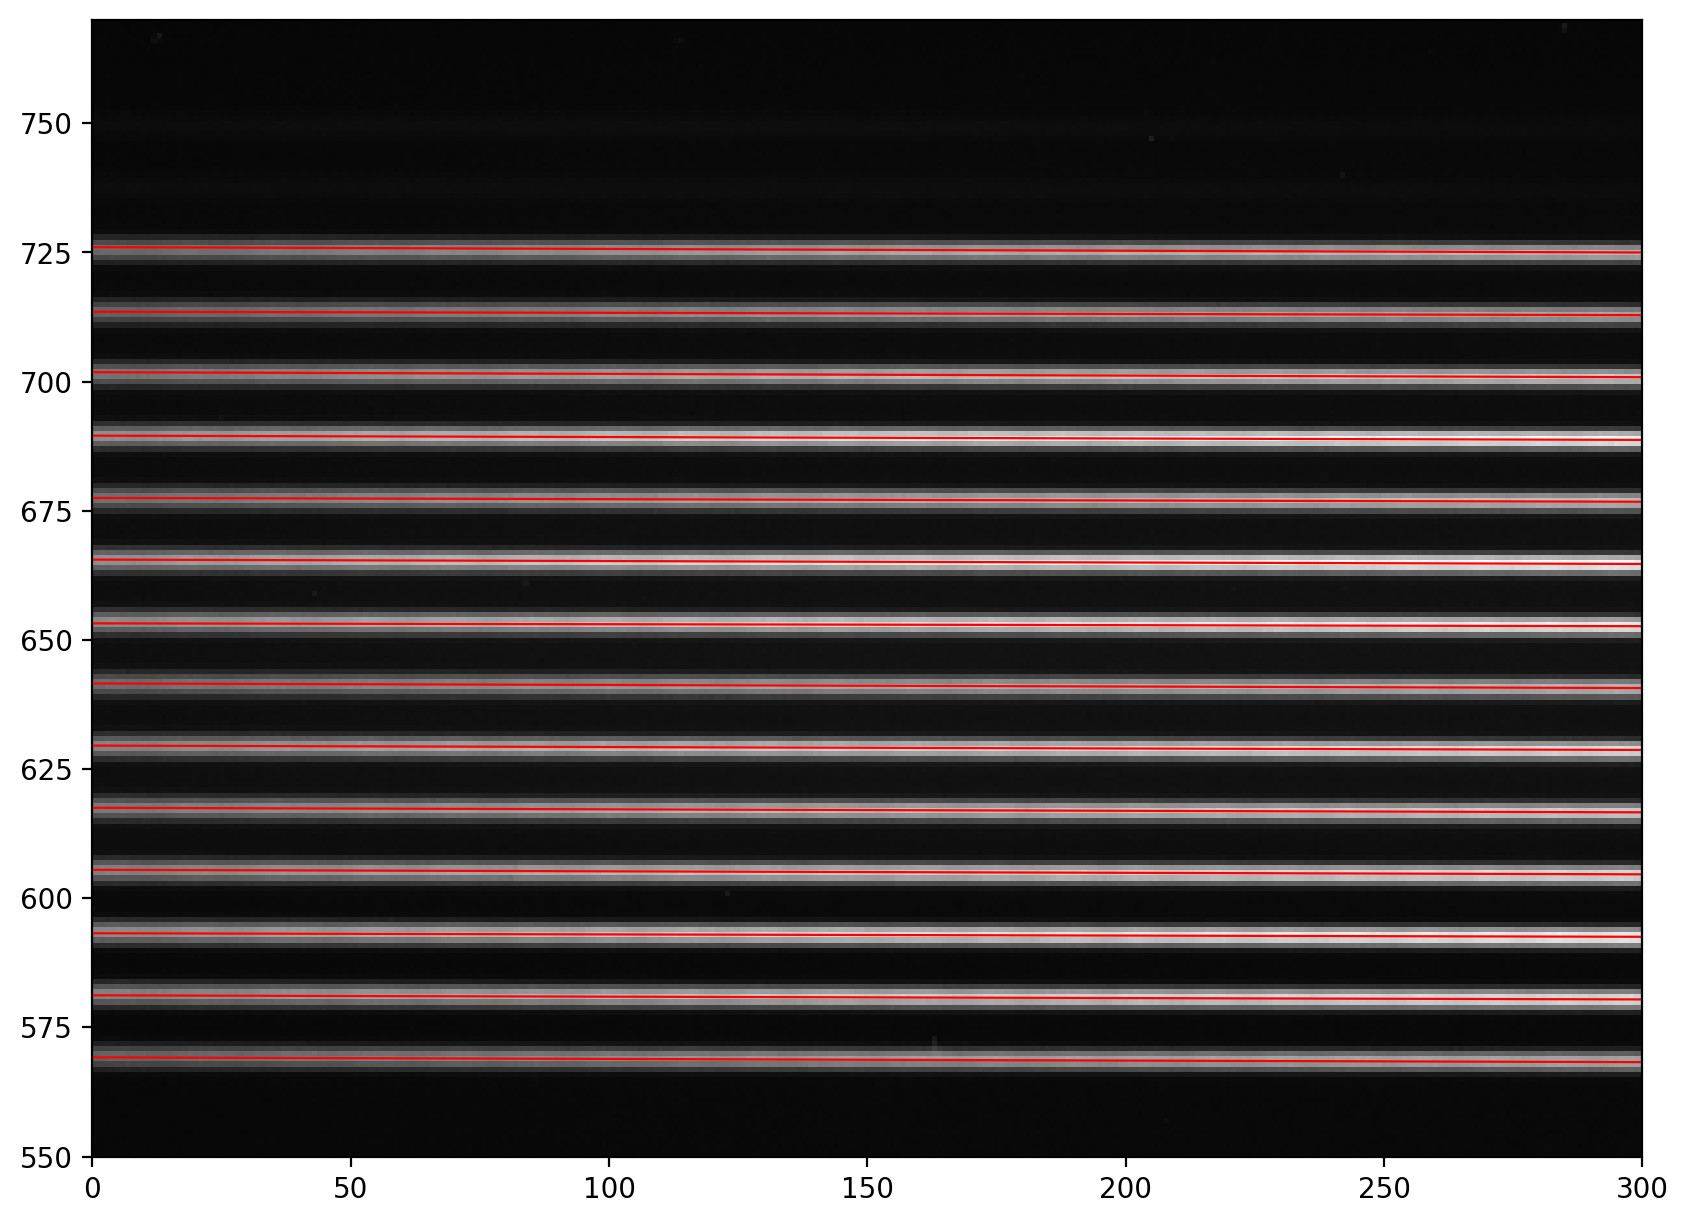

In [128]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower')
for tl in tlm_data:
    ax.plot(np.arange(tl.shape[0]), tl, c="r", lw=0.8)

ax.set_ylim(550, 770)
ax.set_xlim(0, 300)
# ax.set_ylim(1000, 1200)

tlm_data_flat = tlm_data.copy()

In [20]:
from kspecdr.extract.make_ex import make_ex
fpath_ex = mcflat_path.parent / (mcflat_path.stem + "_ex.fits")

args["EXTRAC_FILENAME"] = fpath_ex.as_posix()
args["TLMAP_FILENAME"] = fpath_tlm.as_posix()

make_ex(args)

hdul = fits.open(fpath_ex)

2026-01-23 23:23:22,339 | kspecdr.extract.make_ex | INFO | Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits
2026-01-23 23:23:22,340 | kspecdr.extract.make_ex | INFO | Extraction Method: TRAM
2026-01-23 23:23:22,343 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat.fits (mode: READ)
2026-01-23 23:23:22,348 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits (mode: READ)
2026-01-23 23:23:22,349 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits
2026-01-23 23:23:22,349 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning

2026-01-23 23:23:22,350 | kspecdr.extract.make_ex | INFO | Performing SUM extraction with width=5.0
2026-01-23 23:23:22,711 | kspecdr.extract.make_ex | INFO | Written extracted file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_ex.fits


Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     156   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   
  3  FIBRES        1 BinTableHDU     13   16R x 2C   [1A, 20A]   


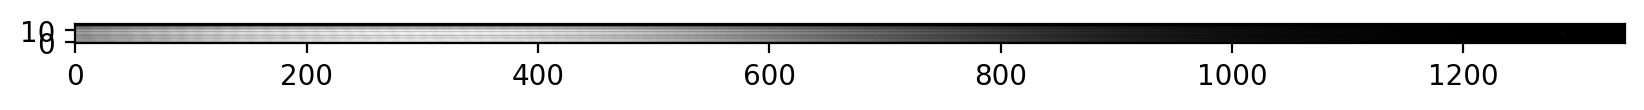

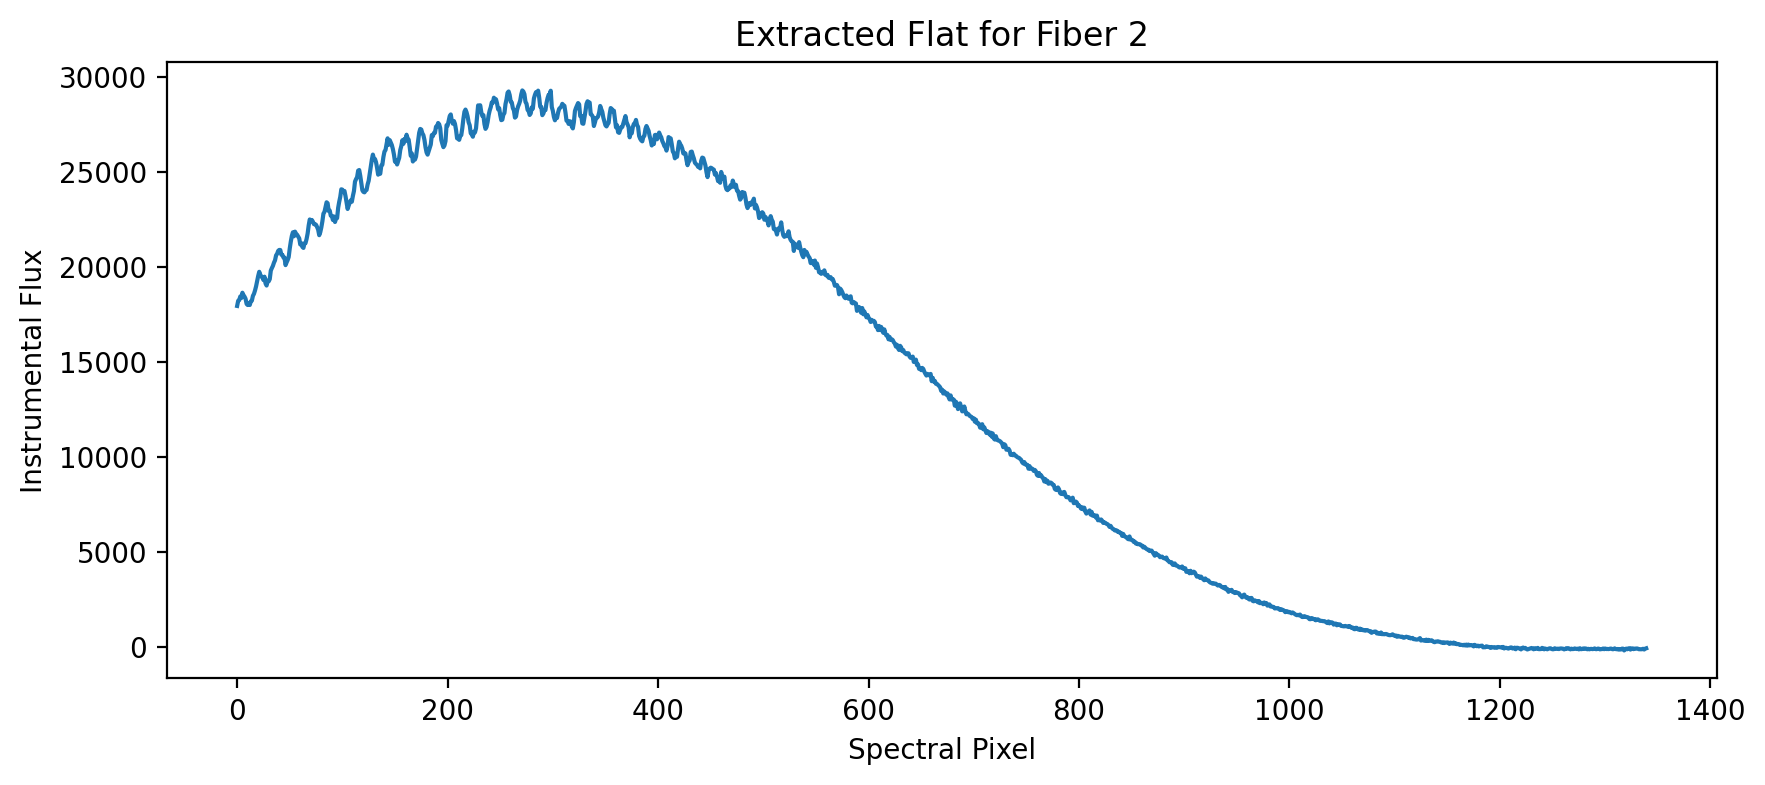

In [21]:
hdul = fits.open(fpath_ex)
hdul.info()

flat_ex = hdul[0].data

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(flat_ex, cmap='gray', origin='lower')
plt.show()

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(flat_ex[1])
ax.set_ylabel("Instrumental Flux")
ax.set_xlabel("Spectral Pixel")
ax.set_title("Extracted Flat for Fiber 2")
plt.show()

In [85]:
arc_list = [TESTDIR / f for f in TESTDIR.glob("arc_*.fits")]

for arc_path in arc_list:
    hdul = fits.open(arc_path)
    hdr = hdul[0].header
    hdul[0].data = hdul[0].data[0]
    new_hdr = convert_isoplane_header(hdr, ndfclass="MFARC")
    hdul[0].header = new_hdr
    add_fiber_table(hdul, n_fibers=14)
    carc_path = arc_path.as_posix().replace("arc_", "carc_")
    hdul.writeto(carc_path, overwrite=True)

    make_im(carc_path,
        cosmic_ray_method='NONE',
        bias_filename=mbias_path.as_posix(),
        use_bias=True,
        verbose=False)

2026-01-24 13:42:49,715 | astropy | WARNING | TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days
2026-01-24 13:42:49,717 | kspecdr.inst.isoplane | INFO | Adding fiber table with 14 fibers


2026-01-24 13:42:49,807 | kspecdr.preproc.make_im | INFO | Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
2026-01-24 13:42:49,808 | kspecdr.preproc.make_im | INFO | Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001_im.fits
2026-01-24 13:42:49,812 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001.fits (mode: READ)
2026-01-24 13:42:49,813 | kspecdr.preproc.make_im | INFO | Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
2026-01-24 13:42:49,813 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001.fits
2026-01-24 13:42:49,821 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001.fits (mode: READ)
2026-01-24 13:42:

In [86]:
fpath_im = TESTDIR / "carc_00002_im.fits"
fpath_tlm = TESTDIR / "carc_00002_tlm.fits"
args = {"IMAGE_FILENAME": fpath_im.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix()}

make_tlm(args)

2026-01-24 13:42:51,760 | kspecdr.tlm.make_tlm | INFO | Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits
2026-01-24 13:42:51,767 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits (mode: READ)
2026-01-24 13:42:51,768 | kspecdr.tlm.make_tlm | INFO | Instrument code: 99
2026-01-24 13:42:51,768 | kspecdr.tlm.make_tlm | INFO | Starting tramline map generation for non-2DF instrument


2026-01-24 13:42:51,780 | kspecdr.tlm.make_tlm | INFO | Fibres officially in use: 14
2026-01-24 13:42:51,781 | kspecdr.tlm.make_tlm | INFO | Fibres potentially able: 0
2026-01-24 13:42:51,781 | kspecdr.tlm.make_tlm | INFO | Fibres officially dead: 0
2026-01-24 13:42:51,781 | kspecdr.tlm.make_tlm | INFO | Max number of traces: 14
2026-01-24 13:42:51,781 | kspecdr.tlm.make_tlm | INFO | Image dimensions: nspec=1340, nspat=1300
2026-01-24 13:42:51,782 | kspecdr.tlm.make_tlm | INFO | Sweeping image for signs of fibre traces...
2026-01-24 13:42:51,782 | kspecdr.tlm.make_tlm | INFO | Processing column 0/1340 (0.0%)
2026-01-24 13:42:51,784 | kspecdr.tlm.make_tlm | INFO | Processing column 50/1340 (3.7%)
2026-01-24 13:42:51,786 | kspecdr.tlm.make_tlm | INFO | Processing column 100/1340 (7.5%)
2026-01-24 13:42:51,787 | kspecdr.tlm.make_tlm | INFO | Processing column 150/1340 (11.2%)
2026-01-24 13:42:51,789 | kspecdr.tlm.make_tlm | INFO | Processing column 200/1340 (14.9%)
2026-01-24 13:42:51,791

2026-01-24 13:42:51,888 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits (mode: READ)
2026-01-24 13:42:51,892 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits


(14, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 14)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 14)   float64   


(1000.0, 1300.0)

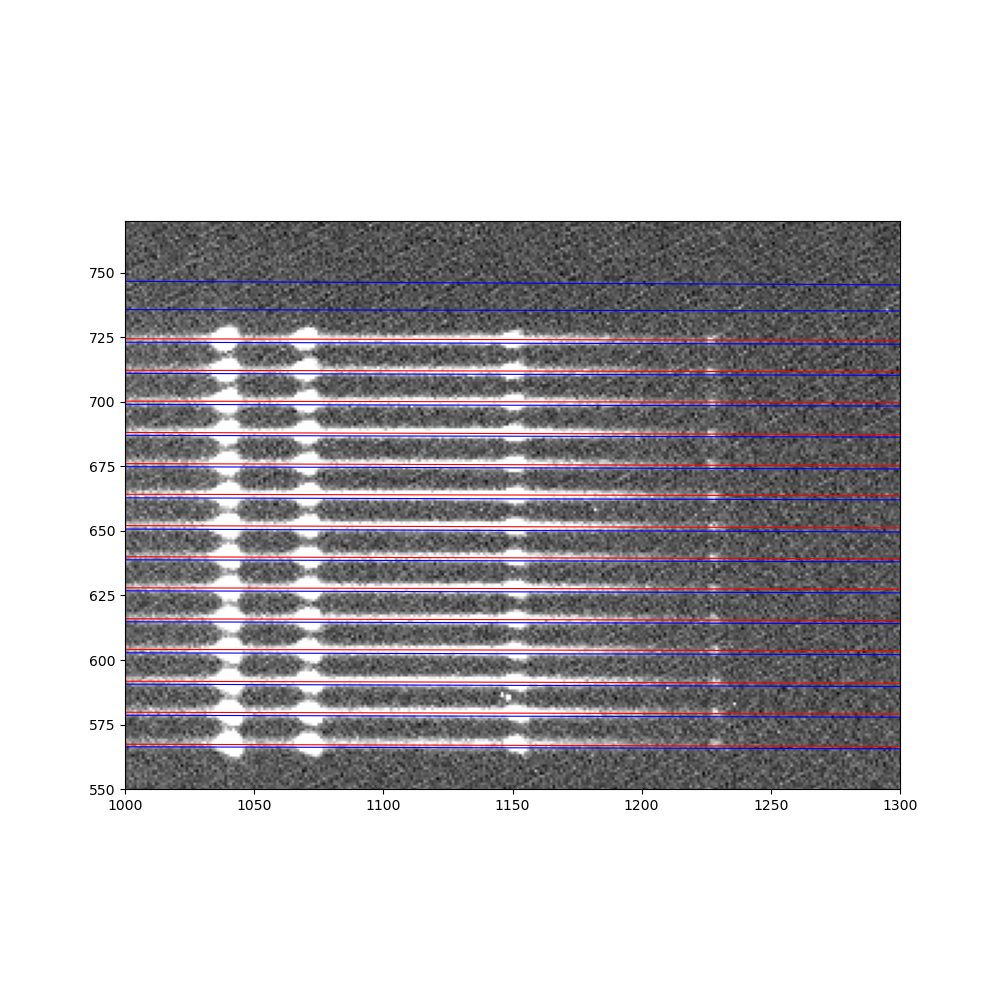

In [87]:
from astropy.visualization import ZScaleInterval

with ImageFile(fpath_im.as_posix(), mode='READ') as im:
    img_data, var_data, fibre_types = read_instrument_data(im, 99)

zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(img_data)

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
for tl in tlm_data:
    ax.plot(np.arange(tl.shape[0]), tl, c="r", lw=0.8)
    
for tl in tlm_data_flat:
    ax.plot(np.arange(tl.shape[0]), tl, c="b", lw=0.8)

ax.set_ylim(550, 770)
ax.set_xlim(1000, 1300)

In [93]:
for i in range(1, 7+1):
    fpath_im = TESTDIR / f"carc_0000{i}_im.fits"
    fpath_tlm = TESTDIR / f"carc_0000{i}_tlm.fits"
    args = {"IMAGE_FILENAME": fpath_im.as_posix(),
            "TLMAP_FILENAME": fpath_tlm.as_posix()}

    make_tlm(args)

2026-01-24 13:44:41,867 | kspecdr.tlm.make_tlm | INFO | Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001_im.fits
2026-01-24 13:44:41,871 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00001_im.fits (mode: READ)
2026-01-24 13:44:41,871 | kspecdr.tlm.make_tlm | INFO | Instrument code: 99
2026-01-24 13:44:41,871 | kspecdr.tlm.make_tlm | INFO | Starting tramline map generation for non-2DF instrument
2026-01-24 13:44:41,876 | kspecdr.tlm.make_tlm | INFO | Fibres officially in use: 14
2026-01-24 13:44:41,876 | kspecdr.tlm.make_tlm | INFO | Fibres potentially able: 0
2026-01-24 13:44:41,876 | kspecdr.tlm.make_tlm | INFO | Fibres officially dead: 0
2026-01-24 13:44:41,876 | kspecdr.tlm.make_tlm | INFO | Max number of traces: 14
2026-01-24 13:44:41,877 | kspecdr.tlm.make_tlm | INFO | Image dimensions: nspec=1340, nspat=1300
2026-01-24 13:44:41,877 | kspecdr.tlm.make_tlm | 

2026-01-24 13:44:41,884 | kspecdr.tlm.make_tlm | INFO | Processing column 200/1340 (14.9%)
2026-01-24 13:44:41,886 | kspecdr.tlm.make_tlm | INFO | Processing column 250/1340 (18.7%)
2026-01-24 13:44:41,887 | kspecdr.tlm.make_tlm | INFO | Processing column 300/1340 (22.4%)
2026-01-24 13:44:41,889 | kspecdr.tlm.make_tlm | INFO | Processing column 350/1340 (26.1%)
2026-01-24 13:44:41,891 | kspecdr.tlm.make_tlm | INFO | Processing column 400/1340 (29.9%)
2026-01-24 13:44:41,892 | kspecdr.tlm.make_tlm | INFO | Processing column 450/1340 (33.6%)
2026-01-24 13:44:41,894 | kspecdr.tlm.make_tlm | INFO | Processing column 500/1340 (37.3%)
2026-01-24 13:44:41,896 | kspecdr.tlm.make_tlm | INFO | Processing column 550/1340 (41.0%)
2026-01-24 13:44:41,897 | kspecdr.tlm.make_tlm | INFO | Processing column 600/1340 (44.8%)
2026-01-24 13:44:41,899 | kspecdr.tlm.make_tlm | INFO | Processing column 650/1340 (48.5%)
2026-01-24 13:44:41,901 | kspecdr.tlm.make_tlm | INFO | Processing column 700/1340 (52.2%)

2026-01-24 13:42:56,445 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00004_im.fits (mode: READ)
2026-01-24 13:42:56,450 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00004_im.fits


(14, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00004_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 14)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 14)   float64   
gratlpmm: 300, lambdac: 4700.0


(550.0, 770.0)

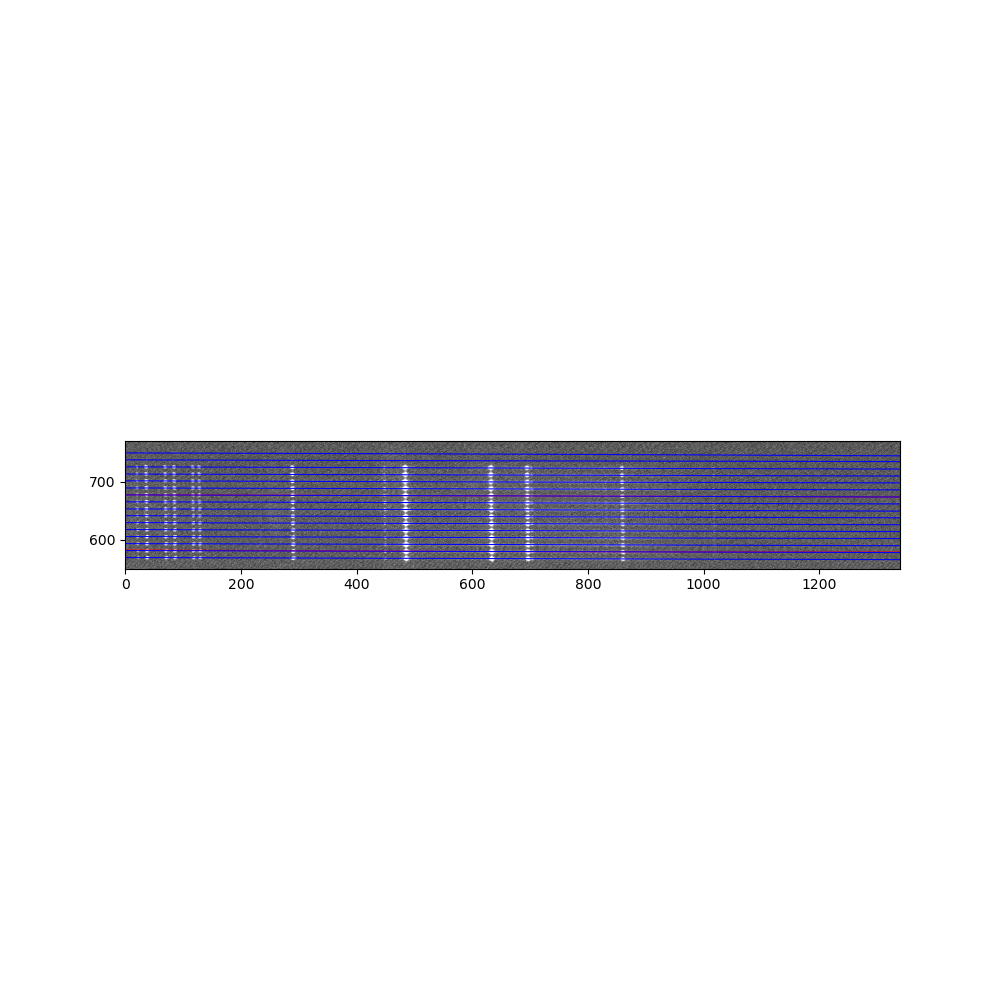

In [89]:
fpath_im = TESTDIR / f"carc_00004_im.fits"
fpath_tlm = TESTDIR / f"carc_00004_tlm.fits"

with ImageFile(fpath_im.as_posix(), mode='READ') as im:
    img_data, var_data, fibre_types = read_instrument_data(im, 99)

zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(img_data)

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()

hdul = fits.open(fpath_im)
gratlpmm = hdul[0].header["GRATLPMM"]
lambdac = hdul[0].header["LAMBDAC"]

print(f"gratlpmm: {gratlpmm}, lambdac: {lambdac}")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
for tl in tlm_data:
    ax.plot(np.arange(tl.shape[0]), tl, c="r", lw=0.8)
    
for tl in tlm_data_flat:
    ax.plot(np.arange(tl.shape[0]), tl, c="b", lw=0.8)

ax.set_ylim(550, 770)
# ax.set_xlim(1000, 1300)
# ax.set_xlim(0, 300)

gratlpmm: 600, lambdac: 4300.0
utmjd: 61059.462118055555


ValueError: operands could not be broadcast together with shapes (12,1340) (14,1340) 

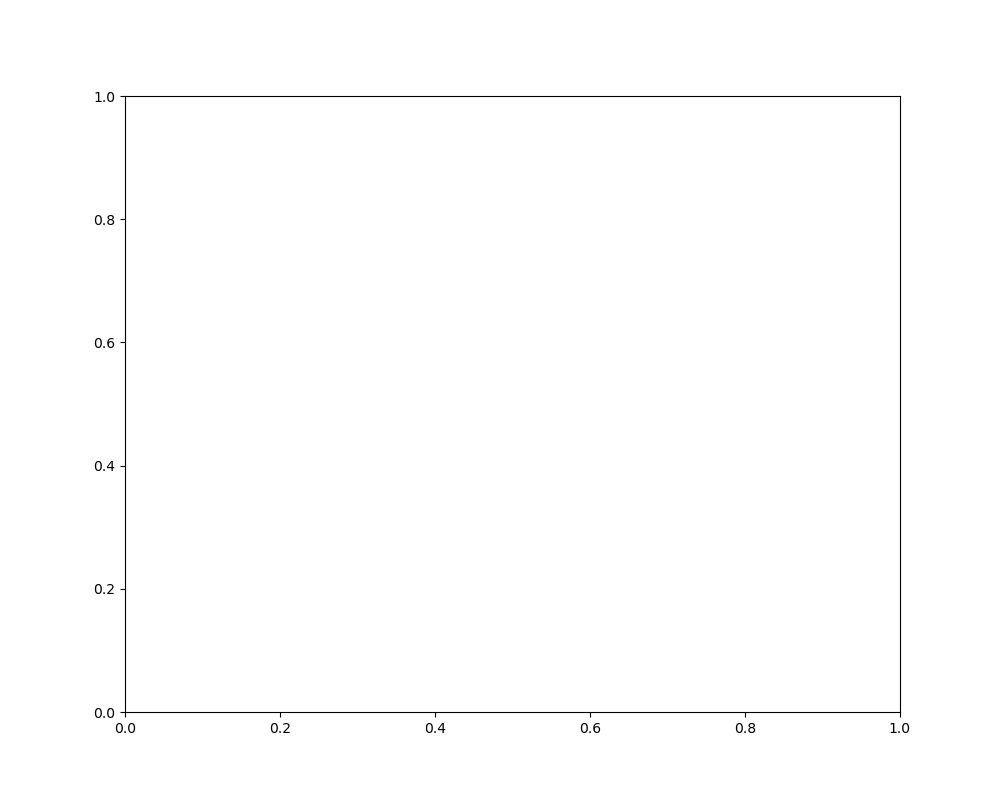

In [90]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

gratlpmm_list = []
lambdac_list = []
utmjd_list = []
diff_list = []
diff_scatter_list = []
for i in range(1, 7+1):
    fpath_im = TESTDIR / f"carc_0000{i}_im.fits"
    fpath_tlm = TESTDIR / f"carc_0000{i}_tlm.fits"

    hdul = fits.open(fpath_tlm)
    tlm_data = hdul[0].data

    hdul = fits.open(fpath_im)
    gratlpmm = hdul[0].header["GRATLPMM"]
    lambdac = hdul[0].header["LAMBDAC"]
    utmjd = hdul[0].header["UTMJD"]

    print(f"gratlpmm: {gratlpmm}, lambdac: {lambdac}")
    print(f"utmjd: {utmjd}")

    if i == 4:
        diff = tlm_data[0] - tlm_data_flat[1]
        diff_scatter = np.zeros(diff.shape)
    else:
        diff = np.mean(tlm_data[:-2] - tlm_data_flat[:-2], axis=0)
        diff_scatter = np.nanstd(tlm_data[:-2] - tlm_data_flat[:-2], axis=0)
        
    gratlpmm_list.append(gratlpmm)
    lambdac_list.append(lambdac)
    utmjd_list.append(utmjd)
    diff_list.append(diff)
    diff_scatter_list.append(diff_scatter)
utmjds = np.array(utmjd_list)
colors = plt.cm.turbo((utmjds - utmjds.min()) / (utmjds.max() - utmjds.min()))
for i in [1,2,3,4,5,6,0]:
    ax.plot(diff_list[i], c=colors[i], label=rf"FARC {gratlpmm_list[i]}/mm, $\lambda_c = {lambdac_list[i]:.0f}\AA$")
    ax.fill_between(np.arange(diff_list[i].shape[0]), diff_list[i] - diff_scatter_list[i], diff_list[i] + diff_scatter_list[i], color=colors[i], alpha=0.1, lw=0)
    
ax.legend()
ax.set_xlabel("Spectral Pixel", fontsize=15)
ax.set_ylabel(r"$\Delta$TLM from FFLAT, 150/mm, 6200$\AA$", fontsize=15)
ax.set_title("TLM Difference for Different Settings", fontsize=15)
ax.legend()
ax.set_xlim(0, 1340)

In [ ]:
mcarc150620_path = new_fpath.parent / "mcarc150620.fits"

combine_image([(TESTDIR / "carc_00002_im.fits").as_posix(), (TESTDIR / "carc_00003_im.fits").as_posix()], 
              output_file=mcarc150620_path.as_posix(),
              method='MEAN',
              adjust_levels=False)

2026-01-23 23:29:20,946 | kspecdr.preproc.preproc | INFO | Combining 2 images into /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620.fits using MEAN
2026-01-23 23:29:20,950 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits (mode: READ)
2026-01-23 23:29:20,950 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits
2026-01-23 23:29:20,951 | kspecdr.preproc.preproc | INFO | Reading /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits (1/2)
2026-01-23 23:29:20,954 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits (mode: READ)


2026-01-23 23:29:20,962 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits
2026-01-23 23:29:20,962 | kspecdr.preproc.preproc | INFO | Reading /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00003_im.fits (2/2)
2026-01-23 23:29:20,965 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00003_im.fits (mode: READ)
2026-01-23 23:29:20,973 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00003_im.fits
2026-01-23 23:29:21,002 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits (mode: READ)
2026-01-23 23:29:21,005 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/carc_00002_im.fits
2026-01-23 23:29:21,035 | kspecdr.preproc.preproc | INFO | C

'/data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620.fits'

In [ ]:
fpath_ex = TESTDIR / "mcarc150620_ex.fits"
fpath_tlm = TESTDIR / "mcflat_tlm.fits"
args = {"IMAGE_FILENAME": mcarc150620_path.as_posix(),
        "EXTRAC_FILENAME": fpath_ex.as_posix(),
        "TLMAP_FILENAME": fpath_tlm.as_posix(),}

make_ex(args)

2026-01-23 23:29:23,808 | kspecdr.extract.make_ex | INFO | Extracting /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620_ex.fits using TLM /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits
2026-01-23 23:29:23,808 | kspecdr.extract.make_ex | INFO | Extraction Method: TRAM
2026-01-23 23:29:23,815 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620.fits (mode: READ)


2026-01-23 23:29:23,831 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits (mode: READ)
2026-01-23 23:29:23,832 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcflat_tlm.fits
2026-01-23 23:29:23,832 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620.fits
2026-01-23 23:29:23,833 | kspecdr.extract.make_ex | INFO | Performing SUM extraction with width=5.0
2026-01-23 23:29:24,191 | kspecdr.extract.make_ex | INFO | Written extracted file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620_ex.fits


Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620_ex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     155   (1340, 16)   float32   
  1  VARIANCE      1 ImageHDU         8   (1340, 16)   float32   
  2  WAVELA        1 ImageHDU         8   (1340, 16)   float32   
  3  FIBRES        1 BinTableHDU     13   16R x 2C   [1A, 20A]   


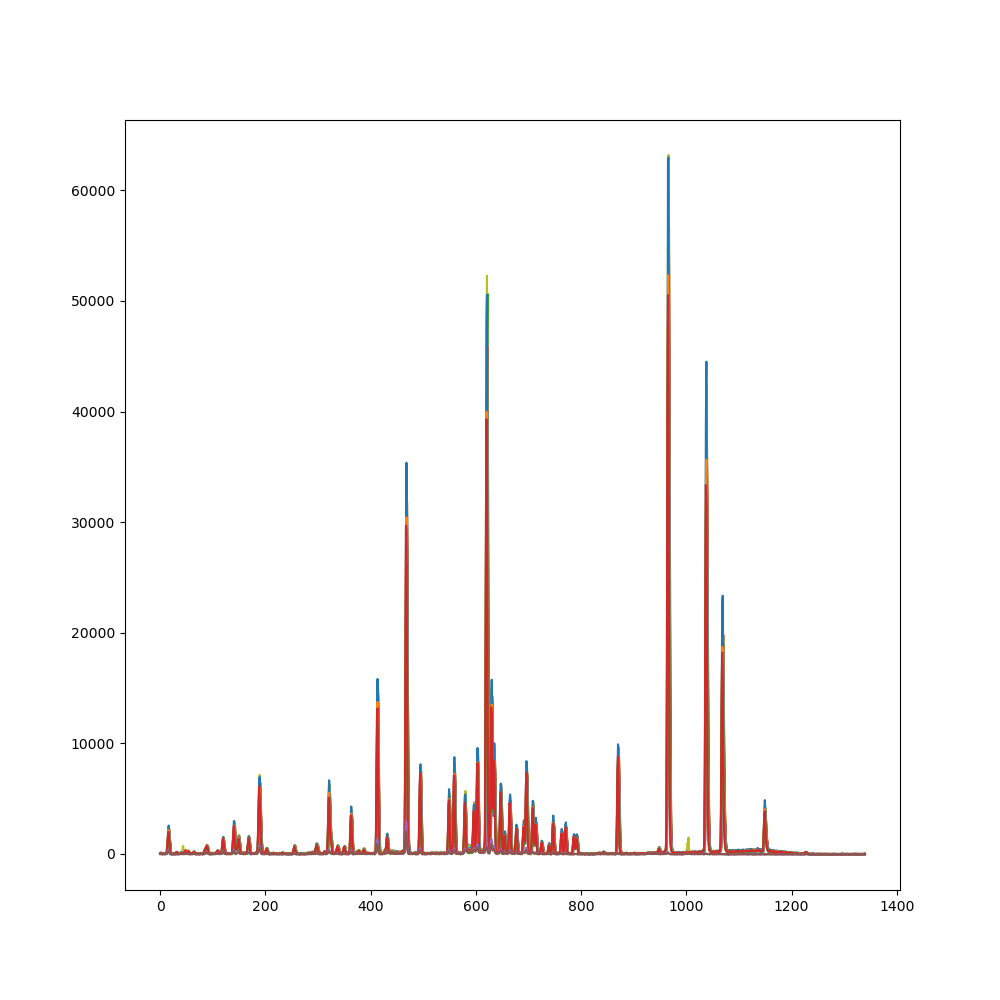

In [ ]:
hdul = fits.open(fpath_ex)
hdul.info()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# ax.imshow(hdul[0].data, cmap='gray', origin='lower')
# ax.set_xlim(800, 900)
ax.plot(hdul[0].data.T)

hgarnekrcd_f8 = hdul[0].data[-8]

In [91]:
from kspecdr.extract.reduce_arc import reduce_arc

arc_args = {
    'IMAGE_FILENAME': (TESTDIR / 'mcarc150620_im.fits').as_posix(),
    'TLMAP_FILENAME': (TESTDIR / 'mcflat_tlm.fits').as_posix(),
    'EXTRAC_FILENAME': (TESTDIR / 'mcarc150620_ex.fits').as_posix(),
    'OUTPUT_FILENAME': (TESTDIR / 'mcarc150620_red.fits').as_posix(),
    'USE_GENCAL': True,
    'ARCDIR': WD/"data"/"arc_tables",
    'LAMPNAME': 'HgArNeKrCd',
}

reduce_arc(arc_args, get_diagnostic=True, diagnostic_dir=TESTDIR / "diagnostic")

2026-01-24 13:43:02,826 | kspecdr.extract.reduce_arc | WARNING | RAW_FILENAME not provided in args. Assuming previous steps completed or files exist.
2026-01-24 13:43:02,843 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/mcarc150620_red.fits (mode: UPDATE)
2026-01-24 13:43:02,844 | kspecdr.extract.reduce_arc | INFO | Using Generic/TAIPAN Calibration Method


2026-01-24 13:43:02,846 | kspecdr.wavecal.arc_io | INFO | Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/HgArNeKrCd.arc
2026-01-24 13:43:02,846 | kspecdr.wavecal.arc_io | INFO | Read 84 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/HgArNeKrCd.arc
2026-01-24 13:43:02,847 | kspecdr.wavecal.calibrate | INFO | Reference fibre: 8
2026-01-24 13:43:02,847 | kspecdr.wavecal.calibrate | INFO | Unique lines: 84
2026-01-24 13:43:02,849 | kspecdr.wavecal.calibrate | INFO | Sigma: 1.45 pix. Noise: Mean=145.45, SD=116.05
2026-01-24 13:43:02,857 | kspecdr.wavecal.calibrate | INFO | Number of landmarks: 41
2026-01-24 13:43:05,194 | kspecdr.wavecal.crosscorr | INFO | Diagnostic output: CrsCgm0.fits
2026-01-24 13:43:05,243 | kspecdr.wavecal.calibrate | INFO | Valid points: 32
2026-01-24 13:43:05,246 | kspecdr.wavecal.calibrate | INFO | Removing 1 outliers.
2026-01-24 13:43:05,249 | kspecdr.wavecal.calibrate | INFO | Median residual: -0.1397, MAD: 1.9663
2026-01-24 13:43:05,249 |

/tmp/ipykernel_3044452/1515400768.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10))


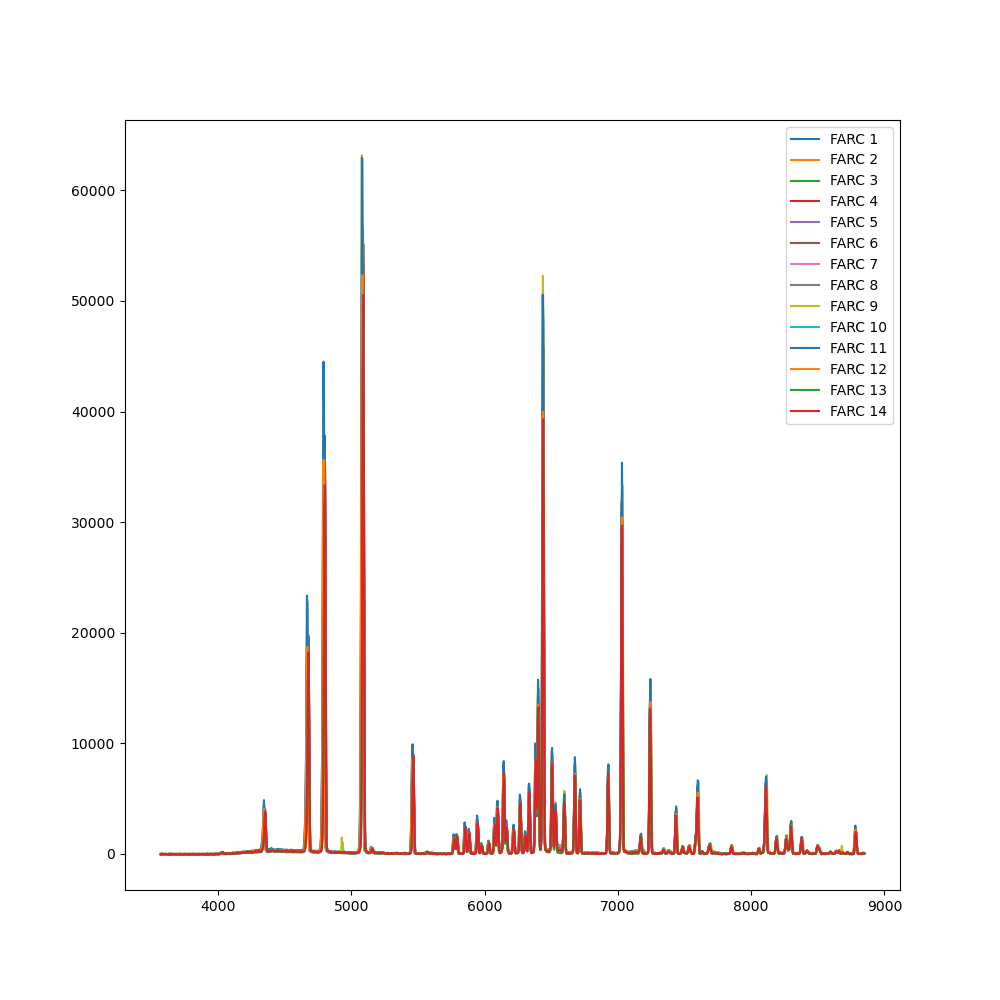

In [92]:
hdul_red = fits.open(TESTDIR / "mcarc150620_red.fits")
wave = hdul_red[2].data[-8]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for i in range(14):
    ww = hdul_red[2].data[i]
    ss = hdul_red[0].data[i]
    ax.plot(ww, ss, label=f"FARC {i+1}")
    
ax.legend()

In [47]:
wavecalid = Table.read(TESTDIR / "diagnostic" / "identified_arcs.dat", format="ascii.fixed_width_two_line")
# coeffs = wavecalid["coeffs"]
x_pts = wavecalid["x_pts"]
y_pts = wavecalid["y_pts"]
residuals = wavecalid["residuals"]
outliers = wavecalid["outliers"].data == "True"

wavecalcoeff = Table.read(TESTDIR / "diagnostic" / "global_fit_coefficients.dat", format="ascii.fixed_width_two_line")
coeffs = wavecalcoeff["coeffs"]

In [48]:
%matplotlib widget

In [83]:
diagnostic_dir = TESTDIR / "diagnostic"
tempspec = Table.read(diagnostic_dir / "TEMPLATE_SPECTRA.dat", format="ascii.csv",
                     names=["wave", "flux"], delimiter=" ")
tempspec

wave,flux
float64,float64
8660.0771,0.0
8656.3945,0.0
8652.7119,0.0
8649.0293,0.0
8645.3462,0.0
8641.6636,0.0
8637.9805,0.0
8634.2979,0.0
8630.6152,21.0393


2026-01-24 13:32:00,932 | kspecdr.wavecal.arc_io | INFO | Reading arc file /data1/hbahk/kspec/kspecdr/data/arc_tables/HgArNeKrCd.arc
2026-01-24 13:32:00,933 | kspecdr.wavecal.arc_io | INFO | Read 90 arc lines from /data1/hbahk/kspec/kspecdr/data/arc_tables/HgArNeKrCd.arc


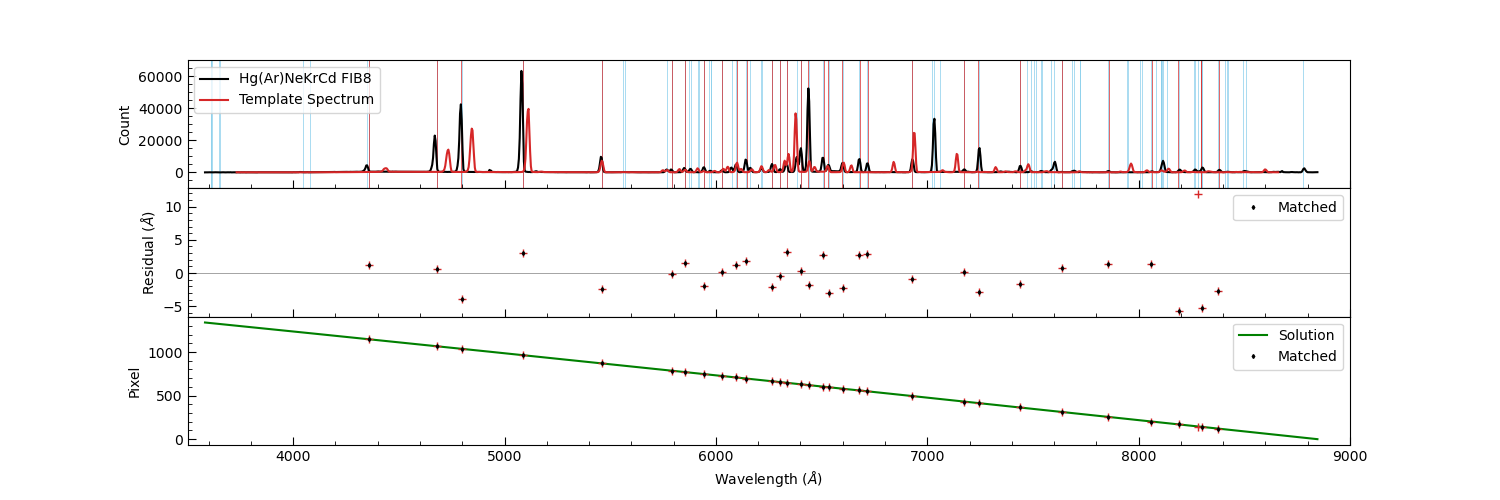

In [84]:
from kspecdr.wavecal.arc_io import read_arc_file

# wave = np.polyval(coeffs, np.arange(1340))


fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
ax = axes[0]
ax.plot(wave, hgarnekrcd_f8, label="Hg(Ar)NeKrCd FIB8", c="k")
ax.plot(tempspec["wave"], tempspec["flux"], label="Template Spectrum", c="tab:red")

nx = 2
xvec = np.array([3000, 9000])
wlist, ilist, labels, nlist = read_arc_file(nx, xvec, "HgArNeKrCd", arc_dir=WD/"data"/"arc_tables")
for i in range(len(wlist)):
    ax.axvline(wlist[i], color="skyblue", lw=0.5, zorder=0)

y_pts_inv = np.polyval(coeffs, x_pts)
for i in range(len(y_pts_inv)):
    ax.axvline(y_pts_inv[i], color="tab:red", lw=0.5, zorder=0)

ax.legend()
# ax.set_yscale("log")
ax.set_xlim(3500, 9000)
ax.set_ylim(-1e4, 7e4)
ax.set_ylabel("Count")

ax = axes[1]
ax.plot(y_pts, residuals, c="tab:red", ls="", marker="+")

ax.plot(y_pts[~outliers], residuals[~outliers], c="k", ls="", marker="d", ms=2, label="Matched")
ax.legend()
ax.axhline(0, c="gray", lw=0.5, zorder=0)
ax.set_ylabel(r"Residual ($\AA$)")

ax = axes[2]
xx = np.arange(1340)
yy = np.polyval(coeffs, xx)
ax.plot(yy, xx, label="Solution", c="green")

ax.plot(y_pts, x_pts, c="tab:red", ls="", marker="+")
ax.plot(y_pts[~outliers], x_pts[~outliers], c="k", ls="", marker="d", ms=2, label="Matched")
ax.legend()
ax.set_xlabel(r"Wavelength ($\AA$)")
ax.set_ylabel("Pixel")
ax.set_xlim(3500, 9000)

ax.legend()

for ax in axes:
    # minor ticks direction in
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in")
    ax.tick_params(which="major", length=6)
    ax.tick_params(which="minor", length=3)

fig.subplots_adjust(hspace=0.0)


In [50]:
x_pts

1146.7018383669083
1066.7129573021894
1037.302962112992
963.5912421056499
870.2274914344182
785.973142954341
769.8370595391067
747.2459240778533
725.0263990669446
707.8786464986421
695.7898898596446


In [44]:
rms = np.sqrt(np.mean(residuals[~outliers]**2))
rms

np.float64(2.3621864578368097)